In [ ]:
! lamin load scprint

In [2]:
import lamindb as ln
import lnschema_bionty as lb

import pandas as pd

from lightning.pytorch import Trainer, seed_everything
seed_everything(42, workers=True)

from scprint import scPrint
from scprint.utils import getBiomartTable

from scdataloader import Dataset
from scdataloader import DataModule
from scprint.dataloader import embed
from scdataloader.utils import load_genes
from scprint.dataloader import Collator

import torch 
torch.set_float32_matmul_precision('medium')

lb.settings.organism = "human"

%load_ext autoreload
%autoreload 2

💡 lamindb instance: jkobject/scprint


2024-02-08 11:37:34,531:INFO - Created a temporary directory at /tmp/tmphmymlkat
2024-02-08 11:37:34,533:INFO - Writing /tmp/tmphmymlkat/_remote_module_non_scriptable.py
INFO: Global seed set to 42
2024-02-08 11:37:34,580:INFO - Global seed set to 42
2024-02-08 11:37:34,533:INFO - Writing /tmp/tmphmymlkat/_remote_module_non_scriptable.py
INFO: Global seed set to 42
2024-02-08 11:37:34,580:INFO - Global seed set to 42
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.p

In [3]:
## Gene embeddings
# embeddings = embed(genedf=genedf,
#     organism="homo_sapiens",
#     cache=True,
#     fasta_path="/tmp/data/fasta/",
#     embedding_size=1024,)
# embeddings.to_parquet('../data/temp/embeddings.parquet')
embeddings = pd.read_parquet('../data/temp/embeddings.parquet')
embeddings.columns = ['emb_'+str(i) for i in embeddings.columns]
# and annotations
biomart = getBiomartTable(attributes=['start_position', 'chromosome_name']).set_index('ensembl_gene_id')
biomart = biomart.loc[~biomart.index.duplicated(keep='first')]
biomart = biomart.sort_values(by=['chromosome_name', 'start_position'])
# and location
c = []
i = 0
prev_position = -100000
prev_chromosome = None
for _, r in biomart.iterrows():
    if r['chromosome_name'] != prev_chromosome or r['start_position'] - prev_position > 10_000:
        i += 1
    c.append(i)
    prev_position = r['start_position']
    prev_chromosome = r['chromosome_name']
print(f'reduced the size to {len(set(c))/len(biomart)}')
biomart['pos'] = c

downloading gene names from biomart
['ensembl_gene_id', 'hgnc_symbol', 'gene_biotype', 'entrezgene_id', 'start_position', 'chromosome_name']


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


reduced the size to 0.6722574020195106



In [4]:
# OR directly load the dataset
name="preprocessed dataset"
dataset = ln.Collection.filter(name=name).first()
dataset.artifacts.count()

91

In [5]:
# TODO: drop tissue & dev stage until part or is taken in account

hierarchical_labels = [
    "cell_type_ontology_term_id", #1
    #"tissue_ontology_term_id",
    "disease_ontology_term_id", # 2
    #"development_stage_ontology_term_id",
    "assay_ontology_term_id", #3
    'self_reported_ethnicity_ontology_term_id', #4
]

labels_weighted_sampling = hierarchical_labels+[
    'sex_ontology_term_id', #5
    "organism_ontology_term_id", #6
]

all_labels = labels_weighted_sampling+[
    #'dataset_id',
    #'cell_culture',
    "heat_diff",
    "total_counts",
    "nnz",
    "dpt_group",
]

In [6]:
mdataset = Dataset(dataset, organisms=["NCBITaxon:9606"], obs=all_labels, clss_to_pred=labels_weighted_sampling, hierarchical_clss=hierarchical_labels)
print(mdataset)

won't do any check but we recommend to have your dataset coming from local storage

82.41758241758242% are aligned
total dataset size is 106.584138411 Gb
---
dataset contains:
     5567614 cells
     70116 genes
     10 labels
     1 organisms
dataset contains 230 classes to predict



In [ ]:
# we might want not to order the genes by expression (or do it?)
# we might want to not introduce zeros and 

In [7]:
d_model = 128
m = torch.nn.AdaptiveAvgPool1d(d_model)
sembeddings = pd.DataFrame(
    data=m(torch.tensor(embeddings.values)), index=embeddings.index, columns=[f'emb_{i}' for i in range(d_model)]
)

In [8]:
decoders = {}
for k, v in mdataset.encoder.items():
    decoders[k] = {va: ke for ke, va in v.items()}

In [9]:
labels = {k: len(v) for k, v in mdataset.class_topred.items()}

cls_hierarchies = {}
for k, dic in mdataset.class_groupings.items():
    rdic = {}
    for sk, v in dic.items():
        rdic[mdataset.encoder[k][sk]] = [mdataset.encoder[k][i] for i in list(v)]
    cls_hierarchies[k] = rdic

df = sembeddings.join(biomart,how="inner")

genedf = load_genes(['NCBITaxon:9606'])
df = df.loc[genedf[genedf.index.isin(df.index)].index]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [10]:
col = Collator(organisms=["NCBITaxon:9606",], how="most expr", valid_genes=df.index.tolist(), max_len=1000, add_zero_genes=100, org_to_id={'NCBITaxon:9606': mdataset.encoder['organism_ontology_term_id']['NCBITaxon:9606']}, tp_name="heat_diff", organism_name="organism_ontology_term_id", class_names=labels_weighted_sampling)#mdataset.encoder['organism_ontology_term_id'])

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [11]:
datamodule = DataModule(mdataset, label_to_weight=labels_weighted_sampling, collate_fn=col, batch_size=32, num_workers=16, validation_split=0.1, test_split=0.1)
datamodule.setup()

these files will be considered test datasets
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695


['/home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad']

In [34]:
model = scPrint(
    genes = df.index.tolist(),
    d_model = d_model,
    nhead = 4,
    d_hid = d_model,
    nlayers = 4,
    layers_cls = [],
    labels = labels,
    cls_hierarchy = cls_hierarchies,
    dropout= 0.1,
    transformer = "flash",
    use_precpt_gene_emb = df.iloc[:,:d_model].values.astype(float),
    gene_pos_enc = df['pos'].tolist(),
    mvc_decoder = "inner product",
    label_decoders = decoders,
)

In [13]:
# create a function to transform an scGPT checkpoint to an scPrint's
# ckpt = torch.load("../../scGPT/save/model_e6.pt")
# scPrint.load_from_checkpoint("../../scGPT/save/model_e6.pt")

In [25]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="scprint_test", save_dir="../data/tensorboard")
wandb_logger.watch(model)

#tlogger = TensorBoardLogger(save_dir="../data/tensorboard")
#tlogger.log_graph(model, i)


2024-02-06 17:18:43,546:ERROR - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jkobject (ml4ig). Use `wandb login --relogin` to force relogin
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
#from lightning.pytorch.profilers import PyTorchProfiler
#pytorch_prof = PyTorchProfiler("../data/tensorboard", emit_nvtx=False, group_by_input_shape=True, record_shapes=True, profile_memory=True, with_stack=True, on_trace_ready=torch.profiler.tensorboard_trace_handler("../data/tensorboard/"),)

In [34]:
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=-1)


In [38]:
# sets seeds for numpy, torch and python.random.
trainer = Trainer(precision=16, profiler="simple")#, gradient_clip_val=10, max_time={"hours": 3}, limit_train_batches=20000, limit_test_batches=0.03, limit_val_batches=3000,logger=wandb_logger, callbacks=[checkpoint_callback]) #detect_anomaly=True, fast_dev_run=20


INFO: Using 16bit Automatic Mixed Precision (AMP)
2024-02-08 13:54:34,704:INFO - Using 16bit Automatic Mixed Precision (AMP)


INFO: GPU available: True (cuda), used: True
2024-02-08 13:54:34,738:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-02-08 13:54:34,742:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-02-08 13:54:34,744:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-02-08 13:54:34,747:INFO - HPU available: False, using: 0 HPUs
2024-02-08 13:54:34,738:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-02-08 13:54:34,742:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-02-08 13:54:34,744:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-02-08 13:54:34,747:INFO - HPU available: False, using: 0 HPUs


these files will be considered test datasets
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-08 13:16:06,281:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type                   | Params
---------------------------------------------------------
0 | gene_encoder  | GeneEncoder            | 4.3 M 
1 | expr_encoder  | ContinuousValueEncoder | 512   
2 | pos_encoder   | PositionalEncoding     | 0     
3 | label_encoder | BatchLabelEncoder      | 1.3 K 
4 | time_encoder  | ContinuousValueEncoder | 512   
5 | transformer   | TransformerEncoder     | 793 K 
6 | expr_decoder  | ExprDecoder            | 34.1 K
7 | cls_decoders  | ModuleDict             | 29.7 K
8 | mvc_decoder   | MVCDecoder             | 65.7 K
9 | sim           | Similarity             | 0     
---------------------------------------------------------
925 K     Trainable params
4.3 M     Non-trainable params
5.3 M     Total params
21.052    Total estimated model params size (MB)
2024-02-08 13:16:06,288:INFO - 
  | Name          | Ty

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 640 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


INFO: `Trainer.fit` stopped: `max_steps=20` reached.
2024-02-08 13:16:25,718:INFO - `Trainer.fit` stopped: `max_steps=20` reached.
INFO: FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                         

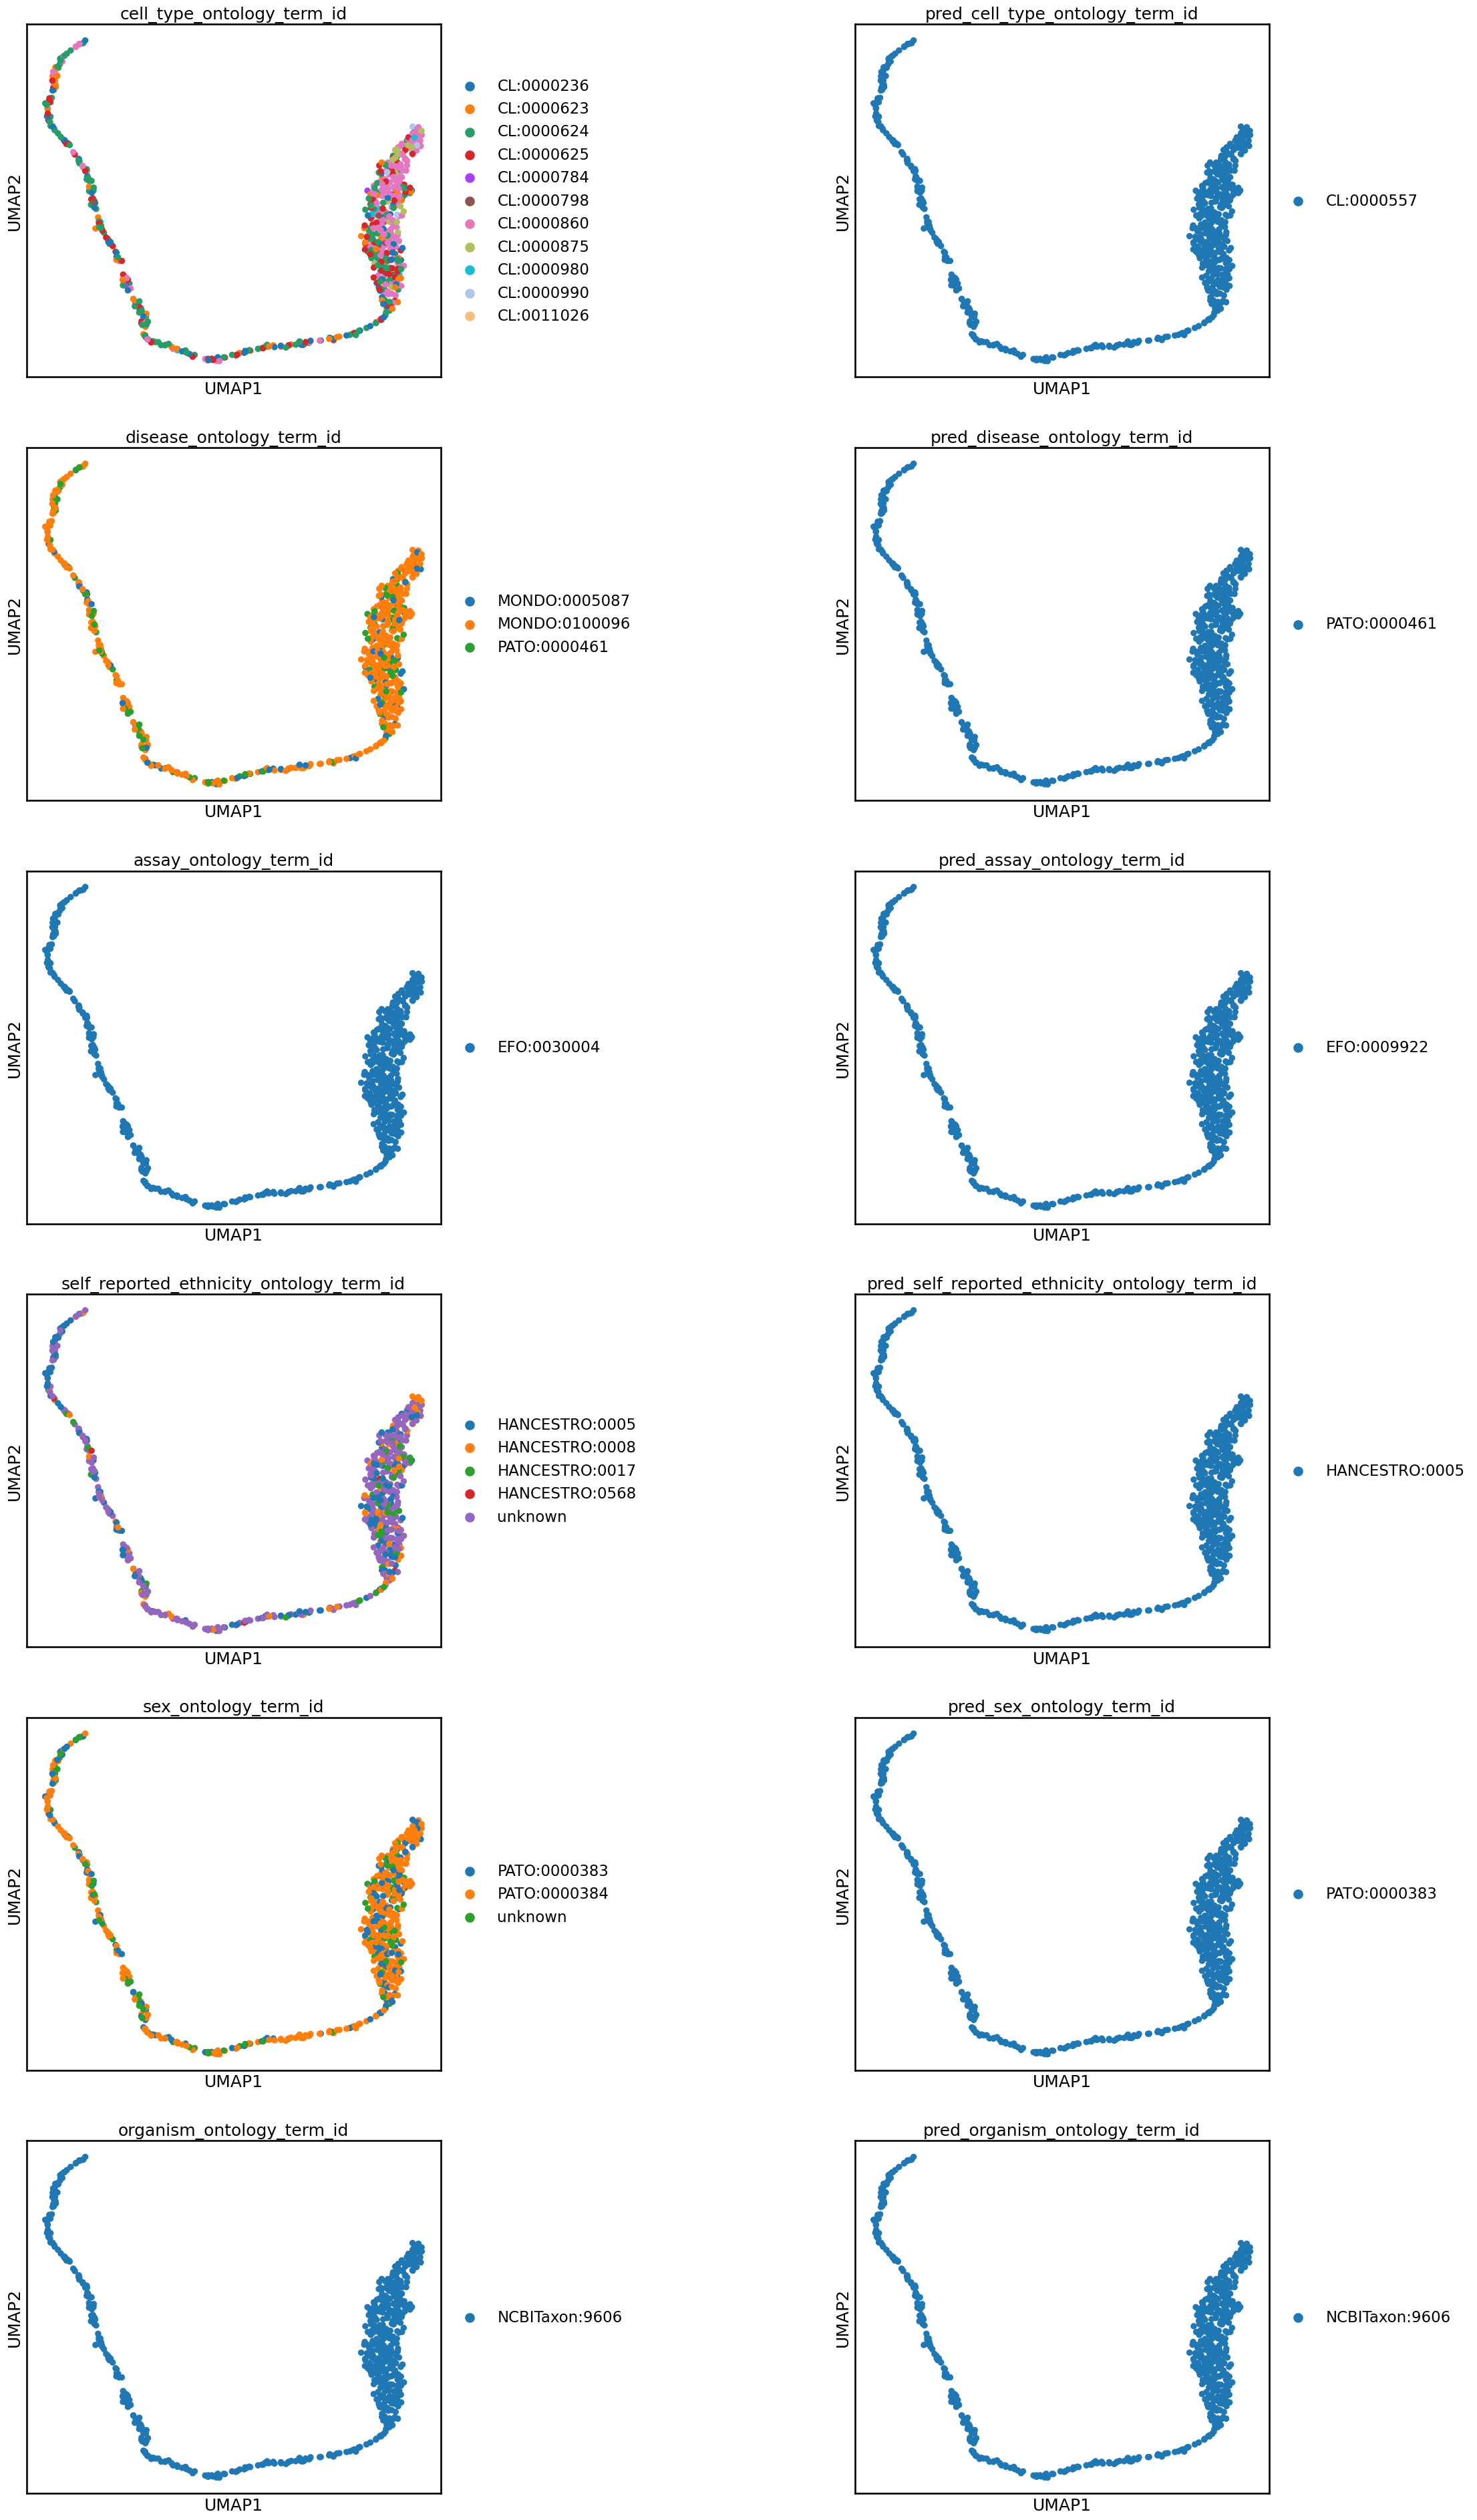

In [30]:
trainer.fit(model, datamodule=datamodule)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir="../data/tensorboard"

In [ ]:
# TODO: log embeddings of N cells + cell type & disease & tissue & sex & predicted version as scanpy plot and log them to wandb 

In [ ]:
2.66 - 128 - noclass - 64 - 8
4.22 - 128 - noclass - 32 - 4
4.50 - 128 - noclass - 32 - 8
9.00 - 128 - 1 MLM   - 32 - 8
5.80 - 256 - 1 MLM   - 32 - 8
2.80 - 256 - noclass - 32 - 8
2.82 - 256 - noclass - 32 - 4
1.70 - 256 - all   - 32 - 8
# I could go 2 times faster with better engineering
# I need to rework the classification task
 - 128 - all - 32 - 8

In [41]:
#wandb_logger.finalize(status="aborted")
torch.cuda.empty_cache()

these files will be considered test datasets
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-08 13:58:35,879:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3200 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB (GPU 0; 19.67 GiB total capacity; 1.30 GiB already allocated; 9.19 MiB free; 1.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

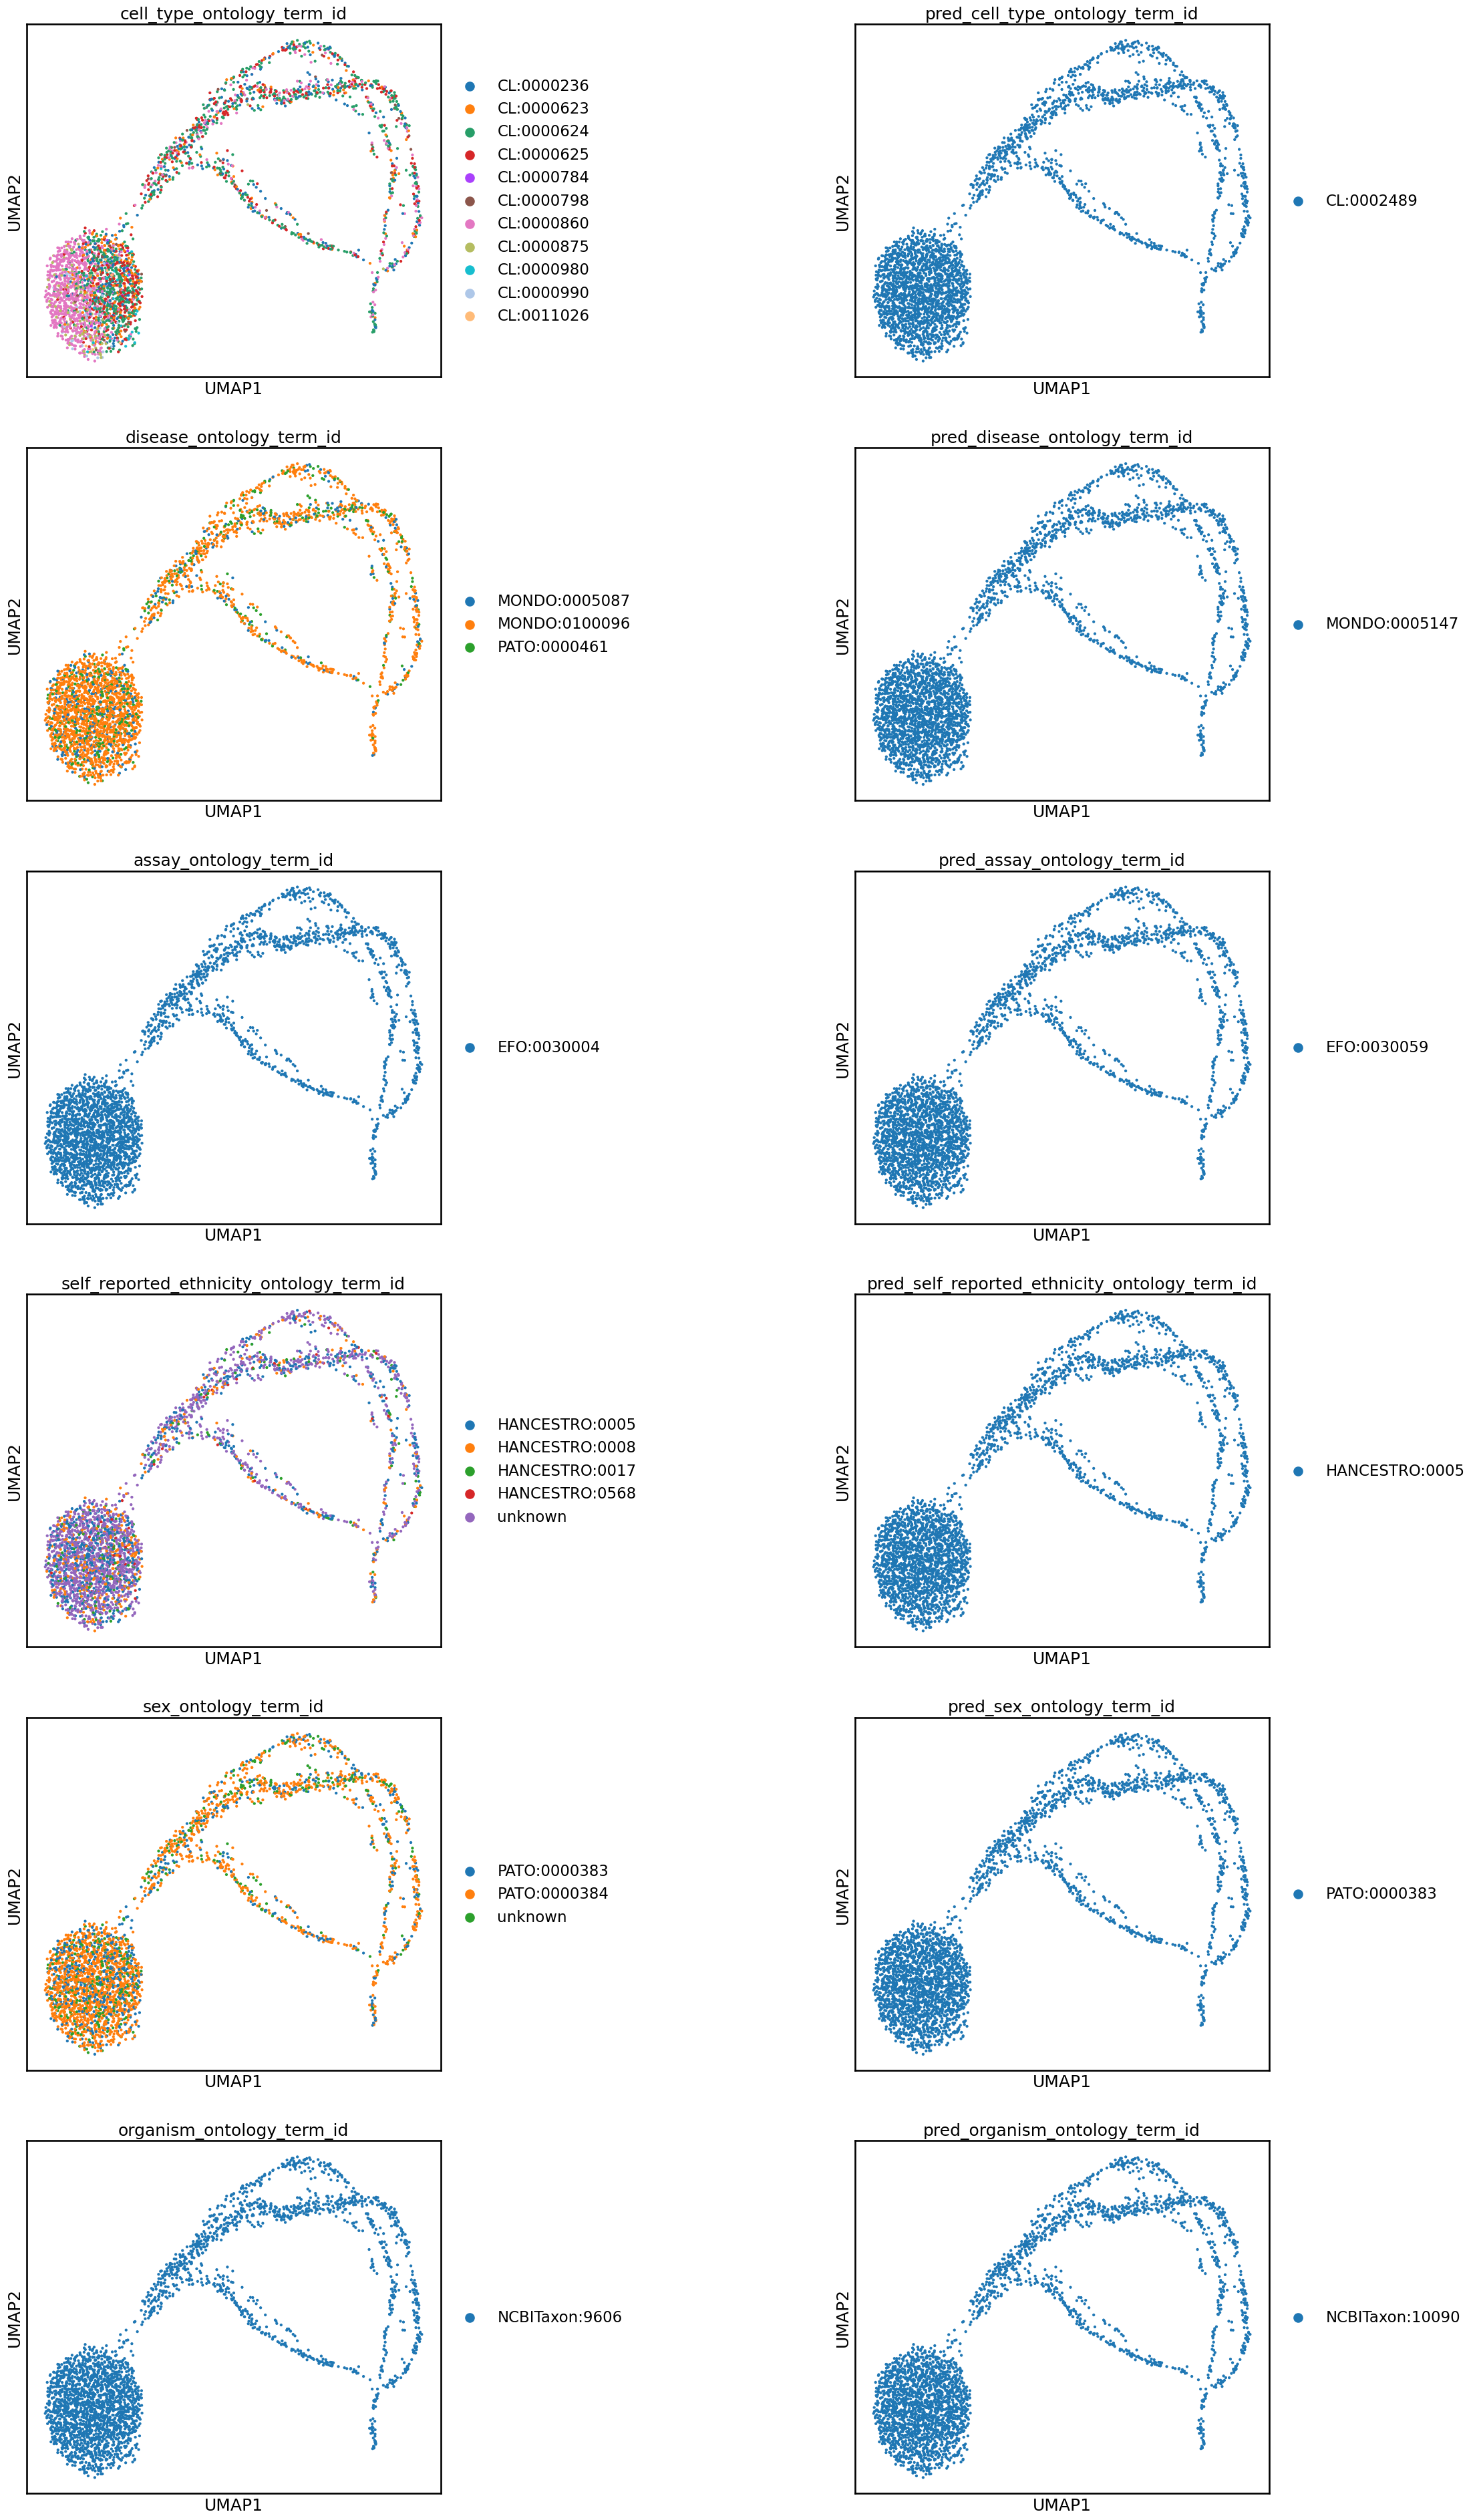

In [40]:
lr_finder = tuner.lr_find(model, datamodule=datamodule)

In [39]:
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
#tuner.scale_batch_size(model, mode="power") #default
lr_finder = tuner.lr_find(model, datamodule=datamodule)

these files will be considered test datasets
    /home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad
perc test:  0.00226129182087695


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-08 13:54:48,712:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [37]:
lr_finder

In [32]:
fig = lr_finder.plot(suggest=True)
fig.show()

AttributeError: 'NoneType' object has no attribute 'plot'

In [ ]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
# update hparams of the model
model.hparams.lr = new_lr

In [ ]:
# TODO: debug how much time is spent on class prediction (0.5 day)
# TODO: test unseen genes (do we see much being kept after filtering and stuff) (0.5 day)
# TODO: visualize and assess the embeddings (0.5 day)
----
# TODO: add model checkpointing (0.5 day) 
# TODO: add method to run the model as a script (0.5 day) ---
# TODO: create env and copy data to maestro (0.5 day)
# TODO: create script and test it on maestro (0.5 day)
# TODO: connect with maestro people to ask for longer compute time 
# TODO: do the same to jean zay (0.5 day)
------
# TODO: make a model benchmark package (continue from where I left off) (4 days)
# TODO: make a task function & make a benchmark function (1 day) (*denoising, *classification, *embeddings, *perturbation prediction)
# TODO: define the test set as a subcollection of datasets (print them and save as a file somewhere too) (0.5 day)
------
# TODO: debug the gene embedding creation
# TODO: create embedding & make it work for the 4-5 species in the dataset (1 days) 
# TODO: debug the timepoint problem (2 days)
# TODO: find the neighboors and next time point cells (1 days)
# TODO: create a version with next time point and neighboors task (1 days)
# TODO: make a trajectory prediction task (predict future cell type/s, expression) and benchmark (similarity to known future cell, similarity to known future expression) (1 days)
------
# TODO: log more info with .log() during training (the model architecture) (some weights? some gradients?) (0.5 day)
# TODO: run a large training on maestro (0.5 day)
------
# TODO: add KO & drug datasets
# TODO: create a version with KO and drug effect prediction